<h1><center> ERFNet Architecture for IDD Lite</center></h1>

In this notebook, we are going to run **ERFNet model** on IDD Lite dataset and check it's performance.  

We already discussed that ERFNet is a type of Encoder-Decoder Architecture which has factorized 1-D resnet modules with dialations in place of non-bottleneck layers which help in training.


The architecture is built of three main modules stacked toegther:

<h3>Factorized Resnet Module with Dialations</h3>
<img src="ss3img/fact.jpeg">

<h3>Downsampling Module</h3>
<img src="ss3img/downsampling.jpeg">

<h3>Upsampling Module</h3>

The total architecture is given in the figure below
<img src="ss3img/erfnetv2.jpeg">


All these images have been borrowed from [Ronny Restrepo](http://ronny.rest/portfolio/erfnet_seg)

<h2><center>Dataset: IDD Lite</center></h2>

We are going to use IDD Lite dataset in this notebook which is smaller version of the recently released [IDD Dataset](http://idd.insaan.iiit.ac.in/media/publications/idd-650.pdf). This dataset contains 673 training images and 110 validation images with L1 level of hierarchy having 7 trainable labels. The dataset can be downloaded from this [link](http://idd.insaan.iiit.ac.in/). More details about the dataset can be gathered from this [paper](http://cvit.iiit.ac.in/images/ConferencePapers/2019/Semantic_Segmentation_NCVPRIPG_19.pdf).

The dataset images are displayed below:

<center>Image</center> | <center> Annotation</center>
- | -
![alt](ss3img/I1.png) | ![alt](ss3img/I1_L1.png)
![alt](ss3img/I2.png) | ![alt](ss3img/I2_L2.png)



In [1]:
#Importing the necessary libraries which can be used !!

import random
import time
import numpy as np
import torch
import math

In [2]:
#Importing library to do image related operations
from PIL import Image, ImageOps

In [3]:
#Importing the important functionalities of Pytorch such as the dataloader, transform's 
#and optimizer related functions.

from torch.utils.data import DataLoader
from torchvision.transforms import  Resize
from torch.optim import SGD, Adam, lr_scheduler
from torchvision.transforms import ToTensor, ToPILImage

In [4]:
# Importing the dataset class for IDD_Lite 
from dataset import idd_lite

#Importing the Relabel, ToLabel and Colorize class from transform.py file
from transform import Relabel, ToLabel, Colorize
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


In [5]:
import importlib
from iouEval import iouEval, getColorEntry #importing iouEval class from the iouEval.py file
from shutil import copyfile

### A few global parameters ###

In [6]:
NUM_CHANNELS = 3 #RGB Images
NUM_CLASSES = 8 #IDD Lite has 8 labels or Level1 hierarchy of labels
USE_CUDA = torch.cuda.is_available() 
IMAGE_HEIGHT = 160
DATA_ROOT = '/ssd_scratch/cvit/amishra/idd1_lite'
BATCH_SIZE = 2
NUM_WORKERS = 4
NUM_EPOCHS = 5
ENCODER_ONLY = True
device = torch.device("cuda" )
color_transform = Colorize(NUM_CLASSES)
image_transform = ToPILImage()

IOUTRAIN = True
IOUVAL = True

In [7]:
#Augmentations - different function implemented to perform random augments on both image and target

class MyCoTransform(object):
    def __init__(self, enc, augment=True, height=160):
        self.enc=enc
        self.augment = augment
        self.height = height
        pass
    def __call__(self, input, target):
        # Resizing data to required size
        input =  Resize((self.height,320), Image.BILINEAR)(input)
        target = Resize((self.height,320), Image.NEAREST)(target)

        if(self.augment):
            # Random horizontal flip
            hflip = random.random()
            if (hflip < 0.5):
                input = input.transpose(Image.FLIP_LEFT_RIGHT)
                target = target.transpose(Image.FLIP_LEFT_RIGHT)
            
            #Random translation 0-2 pixels (fill rest with padding)
            transX = random.randint(0, 2) 
            transY = random.randint(0, 2)

            input = ImageOps.expand(input, border=(transX,transY,0,0), fill=0)
            target = ImageOps.expand(target, border=(transX,transY,0,0), fill=7) #pad label filling with 7
            input = input.crop((0, 0, input.size[0]-transX, input.size[1]-transY))
            target = target.crop((0, 0, target.size[0]-transX, target.size[1]-transY))   

        input = ToTensor()(input)
        
        target = ToLabel()(target)
        
        target = Relabel(255,7)(target)
        return input, target

### Loading Data

We'll follow pytorch recommended semantics, and use a dataloader to load the data. 

In [8]:
best_acc = 0

co_transform = MyCoTransform(ENCODER_ONLY, augment=True, height=IMAGE_HEIGHT)
co_transform_val = MyCoTransform(ENCODER_ONLY, augment=False, height=IMAGE_HEIGHT)

#train data
dataset_train = idd_lite(DATA_ROOT, co_transform, 'train')
print(len(dataset_train))
#val data
dataset_val = idd_lite(DATA_ROOT, co_transform_val, 'val')
print(len(dataset_val))

loader_train = DataLoader(dataset_train, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=True)
loader_val = DataLoader(dataset_val, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=False)


673
110


## Cross Entropy 2D Loss ##


We are going to use Cross Entropy 2D loss for calculating the gradients wrt weights of the network. 

The loss is calculated something like this:
<img src="ss3img/cr2d.png">

A well detailed explanation of this can be found at [Jeremy Jordan's blog](https://www.jeremyjordan.me/semantic-segmentation/#loss).


In [9]:
criterion = torch.nn.CrossEntropyLoss() ## Loss function initialization

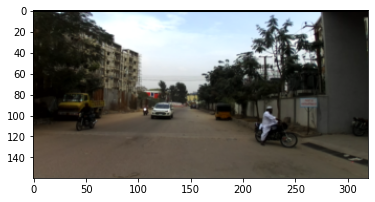

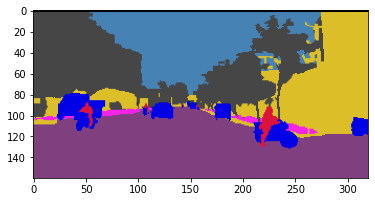

In [10]:
# Get some random training images
dataiter = iter(loader_train)
#print(dataiter.next())
(images, labels) = dataiter.next()
#for step, (images, labels) in enumerate(loader_train):
plt.figure()
plt.imshow(ToPILImage()(images[0].cpu()))
plt.figure()
plt.imshow(ToPILImage()(Colorize()(labels[0].cpu())))  


In this notebook, we are going to use a lighter version of the ERFNet architecture having lesser layers compared to the orginal ERFNet architecture. We have named it as **erfnetv2**. 

In [11]:
model_file = importlib.import_module('erfnetv2')
model = model_file.Net(NUM_CLASSES).to(device)
print(model)

Net(
  (encoder): Encoder(
    (initial_block): DownsamplerBlock(
      (conv): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layers): ModuleList(
      (0): DownsamplerBlock(
        (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): non_bottleneck_1d(
        (conv3x1_1): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (conv1x3_1): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (bn1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (conv3x1_2): Conv2d(64, 64, ker

### Optimizer ###

In [12]:
# We use adam optimizer. It can be replaced with SGD and other optimizers
optimizer = Adam(model.parameters(), 5e-4, (0.9, 0.999),  eps=1e-08, weight_decay=1e-4) 

start_epoch = 1
steps_loss = 50

model = torch.nn.DataParallel(model).to(device)
print(device)

cuda


### Training and Validation Procedure ###

In [13]:
def train_model():

    my_start_time = time.time()
    for epoch in range(start_epoch, NUM_EPOCHS+1):
        print("----- TRAINING - EPOCH", epoch, "-----")

        epoch_loss = []
        time_train = []

        doIouTrain = IOUTRAIN   
        doIouVal =  IOUVAL      

        if (doIouTrain):
            iouEvalTrain = iouEval(NUM_CLASSES)

        model.train()
        for step, (images, labels) in enumerate(loader_train):

            start_time = time.time()
            inputs = images.to(device)
            targets = labels.to(device)

            outputs = model(inputs)
            

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss = criterion(outputs, targets[:, 0])
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            time_train.append(time.time() - start_time)

            if (doIouTrain):
                #start_time_iou = time.time()
                iouEvalTrain.addBatch(outputs.max(1)[1].unsqueeze(1).data, targets.data)
                #print ("Time to add confusion matrix: ", time.time() - start_time_iou)      

            # print statistics
            if steps_loss > 0 and step % steps_loss == 0:
                average = sum(epoch_loss) / len(epoch_loss)
                #print('loss: {average:0.4} (epoch: {epoch}, step: {step})', "// Avg time/img: %.4f s" % (sum(time_train) / len(time_train) / BATCH_SIZE))
                print('Step: , Loss: ', step, average)

        average_epoch_loss_train = sum(epoch_loss) / len(epoch_loss)

        iouTrain = 0
        if (doIouTrain):
            iouTrain, iou_classes = iouEvalTrain.getIoU()
            iouStr = getColorEntry(iouTrain)+'{:0.2f}'.format(iouTrain*100) + '\033[0m'
            print ("EPOCH IoU on TRAIN set: ", iouStr, "%")  
    
        print("----- VALIDATING - EPOCH", epoch, "-----")
        model.eval()
        epoch_loss_val = []
        time_val = []

        if (doIouVal):
            iouEvalVal = iouEval(NUM_CLASSES)

        for step, (images, labels) in enumerate(loader_val):

            start_time = time.time()

            inputs = images.to(device)    
            targets = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs) 
                #outputs = model(inputs)
            loss = criterion(outputs, targets[:, 0])
            epoch_loss_val.append(loss.item())
            time_val.append(time.time() - start_time)


            #Add batch to calculate TP, FP and FN for iou estimation
            if (doIouVal):
                #start_time_iou = time.time()
                iouEvalVal.addBatch(outputs.max(1)[1].unsqueeze(1).data, targets.data)
                #print ("Time to add confusion matrix: ", time.time() - start_time_iou)

            if steps_loss > 0 and step % steps_loss == 0:
                average = sum(epoch_loss_val) / len(epoch_loss_val)
                print('VAL Loss: ', average)
                #print('VAL loss: {average:0.4} (epoch: {epoch}, step: {step})', 
                        #"// Avg time/img: %.4f s" % (sum(time_val) / len(time_val) / BATCH_SIZE))


        average_epoch_loss_val = sum(epoch_loss_val) / len(epoch_loss_val)

        iouVal = 0
        if (doIouVal):

            iouVal, iou_classes = iouEvalVal.getIoU()
            print(iou_classes)
            iouStr = getColorEntry(iouVal)+'{:0.2f}'.format(iouVal*100) + '\033[0m'
            print ("EPOCH IoU on VAL set: ", iouStr, "%") 




In [14]:
train_model()


----- TRAINING - EPOCH 1 -----
Step: , Loss:  0 2.424973249435425
Step: , Loss:  50 2.003166860225154
Step: , Loss:  100 1.7770325193310728
Step: , Loss:  150 1.6107766359847113
Step: , Loss:  200 1.4706572819111952
Step: , Loss:  250 1.3592431834969387
Step: , Loss:  300 1.282090744900941
EPOCH IoU on TRAIN set:  28.17 %
----- VALIDATING - EPOCH 1 -----
VAL Loss:  0.733665943145752
VAL Loss:  0.8542769375969382
tensor([0.8280, 0.0000, 0.0000, 0.2770, 0.0230, 0.6063, 0.8778],
       dtype=torch.float64)
EPOCH IoU on VAL set:  37.32 %
----- TRAINING - EPOCH 2 -----
Step: , Loss:  0 0.8694033622741699
Step: , Loss:  50 0.8342115072643056
Step: , Loss:  100 0.8608466793995092
Step: , Loss:  150 0.8396328210041223
Step: , Loss:  200 0.8222008270410756
Step: , Loss:  250 0.8090852996505115
Step: , Loss:  300 0.8028748790885127
EPOCH IoU on TRAIN set:  37.39 %
----- VALIDATING - EPOCH 2 -----
VAL Loss:  0.6026166677474976
VAL Loss:  0.7751251704552594
tensor([0.8387, 0.0000, 0.0000, 0.3682, 

In [43]:
def visou():
    dataiter = iter(loader_val)
    images, labels = dataiter.next()


    if USE_CUDA:
        img = images.to(device)

    with torch.no_grad():
        outputs = model(img)
        for temp in range(0,outputs.size()[0]):
            label = outputs[temp].max(0)[1].cpu().data
            label_color = Colorize()(label.unsqueeze(0))
            label_save = ToPILImage()(label_color)
            plt.figure()
            plt.imshow(ToPILImage()(images[temp].cpu()))
            plt.figure()
            plt.imshow(label_save)

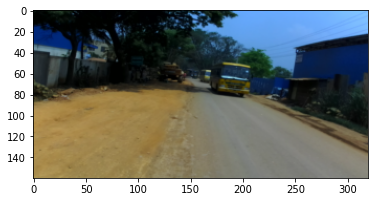

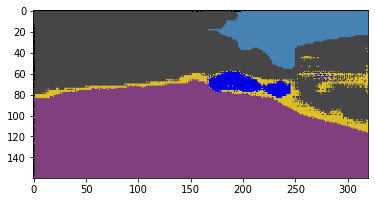

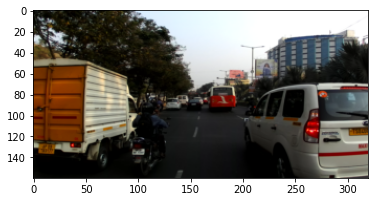

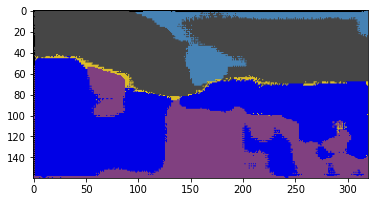

In [44]:
visou()